In [201]:
import os, gzip

import pandas as pd
import numpy as np

from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools

from rdkit import Chem, rdBase, RDConfig
from rdkit.Chem import AllChem, rdShapeHelpers
from rdkit.Chem.FeatMaps import FeatMaps, FeatMapUtils
from rdkit.Chem.FeatMaps.FeatMapUtils import CombineFeatMaps

import plotly.express as px
import plotly.express as px
import plotly.io as pio

In [202]:
# Set the default renderer to png as the data is huge and overwhelms the Javascript renderers
pio.renderers.default = 'png'

In [203]:
# This is pretty well exact copy and paste from the SuCOS code in the Squonk Pipelines project:
# https://github.com/InformaticsMatters/pipelines/blob/master/src/python/pipelines/rdkit/sucos.py
# This code needs improving!!!

# Setting up the features to use in FeatureMap
ffact = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

fmParams = {}
for k in ffact.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')

def filterFeature(f):
    result = f.GetFamily() in keep
    # TODO - nothing ever seems to be filtered. Is this expected?
    if not result:
        print("Filtered out feature type", f.GetFamily())
    return result

def getRawFeatures(mol):
    rawFeats = ffact.GetFeaturesForMol(mol)
    # filter that list down to only include the ones we're interested in
    filtered = list(filter(filterFeature, rawFeats))
    return filtered

def getFeatureMap(mol):
    feats = getRawFeatures(mol)
    return FeatMaps.FeatMap(feats=feats, weights=[1]*len(feats),params=fmParams)

def gen_feats(mol):
    rawFeats = getRawFeatures(mol)
    return FeatMaps.FeatMap(feats=feats, weights=[1]*len(rawFeats), params=fmParams)

def get_FeatureMapScore(small_feats, large_feats, tani=False, score_mode=FeatMaps.FeatMapScoreMode.All):
    """
    Generate the feature map score.

    :param small_feats:
    :param large_feats:
    :param tani:
    :return:
    """

    featLists = []
    for rawFeats in [small_feats, large_feats]:
        # filter that list down to only include the ones we're interested in
        featLists.append(rawFeats)
    fms = [FeatMaps.FeatMap(feats=x, weights=[1] * len(x), params=fmParams) for x in featLists]
    # set the score mode
    fms[0].scoreMode = score_mode

    try:
        if tani:
            c = fms[0].ScoreFeats(featLists[1])
            A = fms[0].GetNumFeatures()
            B = len(featLists[1])
            if B != fms[1].GetNumFeatures():
                print("Why isn't B equal to number of features...?!")
            tani_score = float(c) / (A+B-c)
            return tani_score
        else:
            fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
            return fm_score
    except ZeroDivisionError:
        print("ZeroDivisionError")
        return 0

    if tani:
        tani_score = float(c) / (A+B-c)
        return tani_score
    else:
        fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
        return fm_score

def get_SucosScore(ref_mol, query_mol, tani=False, ref_features=None, query_features=None, score_mode=FeatMaps.FeatMapScoreMode.All):
    """
    This is the key function that calculates the SuCOS scores and is expected to be called from other modules.
    To improve performance you can pre-calculate the features and pass them in as optional parameters to avoid having
    to recalculate them. Use the getRawFeatures function to pre-calculate the features.

    :param ref_mol: The reference molecule to compare to
    :param query_mol: The molecule to compare to the reference
    :param tani: Whether to calculate Tanimoto distances
    :param ref_features: An optional feature map for the reference molecule, avoiding the need to re-calculate it.
    :param query_features: An optional feature map for the query molecule, avoiding the need to re-calculate it.
    :return: A tuple of 3 values. 1 the sucos score, 2 the feature map score,
        3 the Tanimoto distance or 1 minus the protrude distance
    """

    if not ref_features:
        ref_features = getRawFeatures(ref_mol)
    if not query_features:
        query_features = getRawFeatures(query_mol)

    fm_score = get_FeatureMapScore(ref_features, query_features, tani, score_mode)
    fm_score = np.clip(fm_score, 0, 1)

    try :
        if tani:
            tani_sim = 1 - float(rdShapeHelpers.ShapeTanimotoDist(ref_mol, query_mol))
            tani_sim = np.clip(tani_sim, 0, 1)
            SuCOS_score = 0.5*fm_score + 0.5*tani_sim
            return SuCOS_score, fm_score, tani_sim
        else:
            protrude_dist = rdShapeHelpers.ShapeProtrudeDist(ref_mol, query_mol, allowReordering=False)
            protrude_dist = np.clip(protrude_dist, 0, 1)
            protrude_val = 1.0 - protrude_dist
            SuCOS_score = 0.5 * fm_score + 0.5 * protrude_val
            return SuCOS_score, fm_score, protrude_val
    except:
        utils.log("Failed to calculate SuCOS scores. Returning 0,0,0")
        return 0, 0, 0

In [204]:
# Read the 22 non-covalent hits
supplr = Chem.ForwardSDMolSupplier(gzip.open('Mpro_22_data/hits-22.sdf.gz'))
hits = [m for m in supplr]
len(hits)

22

In [205]:
# Quick test that we can generate scores
mol0 = hits[0]
i = 0
for mol1 in hits:
    for mol2 in hits:
        score = get_SucosScore(mol0, mol)
        print('Scores for ', i, ' = ', score)
        i += 1

Scores for  0  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  1  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  2  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  3  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  4  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  5  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  6  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  7  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  8  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  9  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  10  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  11  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  12  =  (0.3077716908507278

Scores for  166  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  167  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  168  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  169  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  170  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  171  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  172  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  173  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  174  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  175  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  176  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  177  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  178 

Scores for  309  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  310  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  311  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  312  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  313  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  314  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  315  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  316  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  317  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  318  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  319  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  320  =  (0.3077716908507278, 0.15420926127642606, 0.4613341204250295)
Scores for  321 

In [206]:
# let's compare the overlaps
i = 0
names = []
data = {}
for mol1 in hits:
    j = 0
    name = mol1.GetProp('_Name')[5:-2]
    names.append(name)
    scores = []
    for mol2 in hits:
        score = get_SucosScore(mol1, mol2)
        scores.append(score[0])
        j += 1
    i += 1
    data[name] = scores
df = pd.DataFrame(data)
df.shape

(22, 22)

In [207]:
df.head()

,x0072,x0104,x0107,x0161,x0195,x0305,x0354,x0387,x0395,x0397,...,x0540,x0678,x0874,x0946,x0967,x0991,x0995,x1077,x1093,x1249
0,1.000000,0.312263,0.062250,0.167198,0.177765,0.334046,0.139475,0.542620,0.381322,0.004512,...,0.000000,0.249277,0.397471,0.152159,0.113043,0.317983,0.000000,0.276186,0.142904,0.290930
1,0.335448,1.000000,0.037395,0.482330,0.499495,0.346940,0.105180,0.286389,0.269690,0.000000,...,0.000000,0.183649,0.326123,0.531504,0.072070,0.000710,0.000000,0.046884,0.133120,0.296291
2,0.048927,0.026507,1.000000,0.022851,0.019527,0.039574,0.010721,0.034509,0.066940,0.283256,...,0.384432,0.622295,0.180489,0.009247,0.412275,0.002835,0.473616,0.093707,0.489700,0.062743
3,0.170791,0.448959,0.028380,1.000000,0.649047,0.192675,0.085130,0.149961,0.166573,0.000133,...,0.000000,0.133390,0.190586,0.883936,0.087891,0.000000,0.000000,0.033196,0.125989,0.146602
4,0.196107,0.493949,0.026968,0.681003,1.000000,0.268035,0.142761,0.193219,0.188687,0.000000,...,0.000000,0.141632,0.206632,0.772596,0.074081,0.001054,0.000000,0.057346,0.137522,0.174902


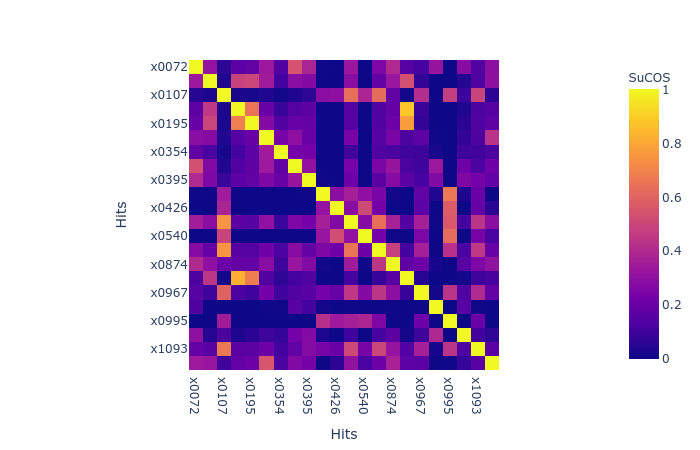

In [208]:
#S o how does this look?
fig = px.imshow(df, labels=dict(x="Hits", y="Hits", color="SuCOS"),
                x=names,
                y=names
               )
fig.show()
# As expexcted some hits overlap to a differin degree

In [209]:
# combining 2 feature maps (no merge)
feat0 = getFeatureMap(hits[0])
feat1 = getFeatureMap(hits[1])
merged = CombineFeatMaps(feat0, feat1)
print(feat0)
print(feat1)
print(merged)
# 7 + 10 = 17
# feature maps combined but not merged

  1        Donor  8.4960 -3.4980  24.5920  1.0000
  2     Acceptor  7.1910 -5.0190  26.2290  1.0000
  3     Acceptor  8.4340 -3.4430  27.2120  1.0000
  4     Aromatic  12.0743 -0.3665  23.1487  1.0000
  5   Hydrophobe  10.8760 -1.0500  23.1440  1.0000
  6   Hydrophobe  9.5680 -1.8260  23.1510  1.0000
  7 LumpedHydrophobe  12.0743 -0.3665  23.1487  1.0000

  1        Donor  12.0740  5.3880  23.6220  1.0000
  2        Donor  10.5720  1.3010  24.5250  1.0000
  3     Acceptor  10.4660  6.3160  24.8740  1.0000
  4     Acceptor  13.7690 -1.8980  21.4040  1.0000
  5     Aromatic  11.4848  1.4778  23.8542  1.0000
  6     Aromatic  12.0783 -0.4323  23.0108  1.0000
  7   Hydrophobe  12.2100  2.3170  23.4570  1.0000
  8   Hydrophobe  12.2670  0.9460  23.1470  1.0000
  9   Hydrophobe  13.1760  3.3750  22.9180  1.0000
 10 LumpedHydrophobe  12.0783 -0.4323  23.0108  1.0000

  1        Donor  8.4960 -3.4980  24.5920  1.0000
  2     Acceptor  7.1910 -5.0190  26.2290  1.0000
  3     Acceptor  8.4340 -3

In [210]:
# combining 2 feature maps (with merge)
feat0 = getFeatureMap(hits[0])
feat1 = getFeatureMap(hits[1])
merged = CombineFeatMaps(feat0, feat1, mergeMetric=1, mergeTol=1.5, dirMergeMode=1)
print(feat0)
print(feat1)
print(merged)
# we get 2 less features. Something is being merged!

  1        Donor  8.4960 -3.4980  24.5920  1.0000
  2     Acceptor  7.1910 -5.0190  26.2290  1.0000
  3     Acceptor  8.4340 -3.4430  27.2120  1.0000
  4     Aromatic  12.0743 -0.3665  23.1487  1.0000
  5   Hydrophobe  10.8760 -1.0500  23.1440  1.0000
  6   Hydrophobe  9.5680 -1.8260  23.1510  1.0000
  7 LumpedHydrophobe  12.0743 -0.3665  23.1487  1.0000

  1        Donor  12.0740  5.3880  23.6220  1.0000
  2        Donor  10.5720  1.3010  24.5250  1.0000
  3     Acceptor  10.4660  6.3160  24.8740  1.0000
  4     Acceptor  13.7690 -1.8980  21.4040  1.0000
  5     Aromatic  11.4848  1.4778  23.8542  1.0000
  6     Aromatic  12.0783 -0.4323  23.0108  1.0000
  7   Hydrophobe  12.2100  2.3170  23.4570  1.0000
  8   Hydrophobe  12.2670  0.9460  23.1470  1.0000
  9   Hydrophobe  13.1760  3.3750  22.9180  1.0000
 10 LumpedHydrophobe  12.0783 -0.4323  23.0108  1.0000

  1        Donor  8.4960 -3.4980  24.5920  1.0000
  2     Acceptor  7.1910 -5.0190  26.2290  1.0000
  3     Acceptor  8.4340 -3

In [211]:
# simplistic merging - merge in the order the molecules are in the file
featMaps = []
total_feature_count = 0
for mol in hits:
    featMap = getFeatureMap(mol)
    print('Processing mol', mol.GetProp('_Name'), 'found', featMap.GetNumFeatures())
    total_feature_count += featMap.GetNumFeatures()
    featMaps.append(featMap)
print('Generated', total_feature_count, 'features')

merged = None
for featMap in featMaps:
    #print(featMap)
    if not merged:
        merged = featMap
    else:
        merged = CombineFeatMaps(merged, featMap,  mergeMetric=1, mergeTol=1.5, dirMergeMode=1)
        
print(merged)

# 156 features are merged down to 88.
    

Processing mol Mpro-x0072_0 found 7
Processing mol Mpro-x0104_0 found 10
Processing mol Mpro-x0107_0 found 5
Processing mol Mpro-x0161_0 found 9
Processing mol Mpro-x0195_0 found 7
Processing mol Mpro-x0305_0 found 4
Processing mol Mpro-x0354_0 found 8
Processing mol Mpro-x0387_0 found 7
Processing mol Mpro-x0395_0 found 6
Processing mol Mpro-x0397_0 found 5
Processing mol Mpro-x0426_0 found 10
Processing mol Mpro-x0434_0 found 7
Processing mol Mpro-x0540_0 found 7
Processing mol Mpro-x0678_0 found 7
Processing mol Mpro-x0874_0 found 8
Processing mol Mpro-x0946_0 found 7
Processing mol Mpro-x0967_0 found 12
Processing mol Mpro-x0991_0 found 3
Processing mol Mpro-x0995_0 found 4
Processing mol Mpro-x1077_0 found 3
Processing mol Mpro-x1093_0 found 12
Processing mol Mpro-x1249_0 found 8
Generated 156 features
  1        Donor  8.4960 -3.4980  24.5920  1.0000
  2     Acceptor  7.1910 -5.0190  26.2290  1.0000
  3     Acceptor  8.4485 -3.1780  26.7635  1.0000
  4     Aromatic  11.9191 -0.39

In [212]:
# see what happens if we reverse the order of the mols
featMaps = []
total_feature_count = 0
for mol in reversed(hits):
    featMap = getFeatureMap(mol)
    print('Processing mol', mol.GetProp('_Name'), 'found', featMap.GetNumFeatures())
    total_feature_count += featMap.GetNumFeatures()
    featMaps.append(featMap)
print('Generated', total_feature_count, 'features')

merged = None
for featMap in featMaps:
    #print(featMap)
    if not merged:
        merged = featMap
    else:
        merged = CombineFeatMaps(merged, featMap,  mergeMetric=1, mergeTol=1.5, dirMergeMode=1)
        
print(merged)

# still get 88 features. Does the order matter?
# but the data is not identical, so beware.
    

Processing mol Mpro-x1249_0 found 8
Processing mol Mpro-x1093_0 found 12
Processing mol Mpro-x1077_0 found 3
Processing mol Mpro-x0995_0 found 4
Processing mol Mpro-x0991_0 found 3
Processing mol Mpro-x0967_0 found 12
Processing mol Mpro-x0946_0 found 7
Processing mol Mpro-x0874_0 found 8
Processing mol Mpro-x0678_0 found 7
Processing mol Mpro-x0540_0 found 7
Processing mol Mpro-x0434_0 found 7
Processing mol Mpro-x0426_0 found 10
Processing mol Mpro-x0397_0 found 5
Processing mol Mpro-x0395_0 found 6
Processing mol Mpro-x0387_0 found 7
Processing mol Mpro-x0354_0 found 8
Processing mol Mpro-x0305_0 found 4
Processing mol Mpro-x0195_0 found 7
Processing mol Mpro-x0161_0 found 9
Processing mol Mpro-x0107_0 found 5
Processing mol Mpro-x0104_0 found 10
Processing mol Mpro-x0072_0 found 7
Generated 156 features
  1        Donor  8.5420  0.5850  24.9250  1.0000
  2        Donor  6.4250  0.8450  23.8150  1.0000
  3     Acceptor  8.2640  2.3450  23.4580  1.0000
  4     Acceptor  3.2905  1.144

In [213]:
# Let's ignore the ordering question for now. Let's just score some molecules - the original hits.
# We'd expect them to all score close to 1

for featMap in featMaps:
    score = featMap.ScoreFeats(merged.GetFeatures()) / featMap.GetNumFeatures()
    print(score)
    
# they do. All score ~1 so that's what we expect. 

0.9692197152798209
0.8767898998682414
1.0919584646821712
0.8808624639535838
1.050692850887956
0.8990292565126191
1.0098903027372204
1.0023168433178915
0.9438127352998709
0.9611761617728355
0.8929044228439188
1.0069931494318904
0.8606590750606907
0.9386005891323633
1.026505395300554
0.9606213679681885
1.034269622940105
0.922896416838558
1.0416622399159845
1.0062275119435093
1.053847821145185
1.163316680086732


In [214]:
# How about some candidates?
# These are 0.2% of Mpro-x0107 hit expanded and enumerate (charge states)
#   docked into Mpro-0387 using tethered docking. 
gz = gzip.open('tethering/Mpro-x0107_into_x0387.sdf.gz')
supplr = Chem.ForwardSDMolSupplier(gz)
tethered_poses = []
count = 0
for m in supplr:
    if count % 200 == 0:
        tethered_poses.append(m)
    count += 1
len(tethered_poses)

232

In [215]:
# let's compare the individual overlaps
i = 0
data = {}
x_names = []
y_names = []

for mol2 in tethered_poses:
    name = mol2.GetProp('_Name')
    y_names.append(name)

for mol1 in hits:
    j = 0
    name = mol1.GetProp('_Name')
    x_names.append(name)
    scores = []
    for mol2 in tethered_poses:
        score = get_SucosScore(mol1, mol2)
        scores.append(score[0])
        j += 1
    i += 1
    data[name] = scores
df2 = pd.DataFrame(data)
print(df2.shape)
print(len(x_names))
print(len(y_names))

(232, 22)
22
232


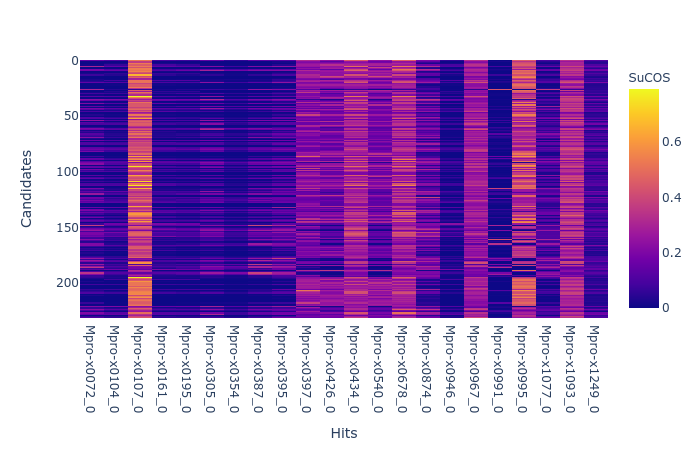

In [216]:
fig = px.imshow(df2, labels=dict(x="Hits", y="Candidates", color="SuCOS"),
                x=x_names
               )
fig.show()

# Not surprisingly Mpro-x0107 scores best as that's what these ligands were tethered to when docked
# TODO - We should remove the originating hit from the comparison. 

In [217]:
count = 0
scores = []
for mol in tethered_poses:
    name = mol.GetProp('_Name')
    featMap = getFeatureMap(mol)
    score = featMap.ScoreFeats(merged.GetFeatures()) / featMap.GetNumFeatures()
    scores.append(score)
    #print(count, name, mol.GetProp('SCORE.norm'), score)
    count += 1
df3 = pd.DataFrame({'scores': scores})

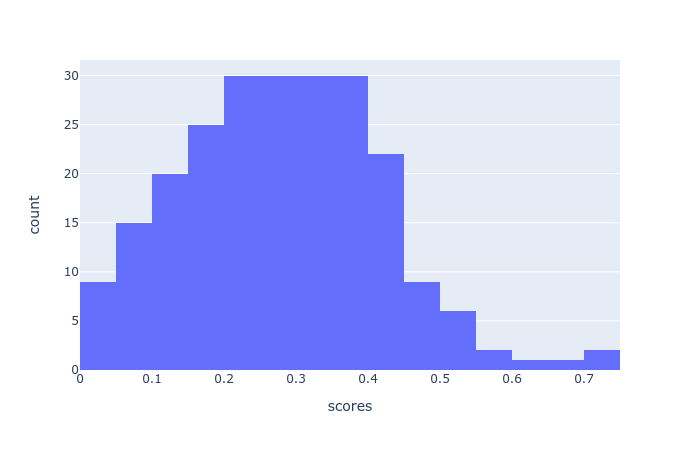

In [218]:
fig = px.histogram(df3,  x='scores')
fig.show()
# We get a reasonable distribution of scores
# Are they usefull?

In [219]:
# look at untethered docking
gz = gzip.open('Mpro_16_data/Mpro-x0387.sdf.gz')
supplr = Chem.ForwardSDMolSupplier(gz)
free_poses = []
count = 0
for m in supplr:
    if count % 200 == 0:
        free_poses.append(m)
    count += 1
len(free_poses)


208

In [220]:
# let's compare the individual overlaps
i = 0
free_data = {}
x_names_free = []
y_names_free = []

for mol2 in free_poses:
    name = mol2.GetProp('_Name')
    y_names_free.append(name)

for mol1 in hits:
    j = 0
    name = mol1.GetProp('_Name')
    x_names_free.append(name)
    scores = []
    for mol2 in free_poses:
        score = get_SucosScore(mol1, mol2)
        scores.append(score[0])
        j += 1
    i += 1
    free_data[name] = scores
df_free = pd.DataFrame(free_data)
print(df_free.shape)
print(len(x_names_free))
print(len(y_names_free))

(208, 22)
22
208


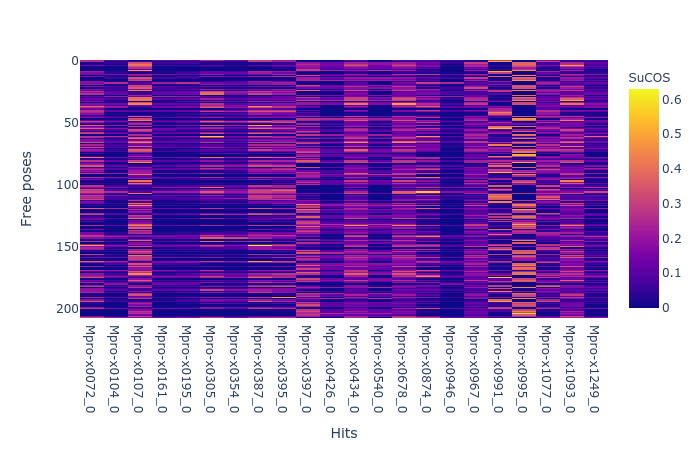

In [221]:
fig = px.imshow(df_free, labels=dict(x="Hits", y="Free poses", color="SuCOS"), x=x_names_free)
fig.show()

In [222]:
count = 0
scores = []
for mol in free_poses:
    name = mol.GetProp('_Name')
    featMap = getFeatureMap(mol)
    score = featMap.ScoreFeats(merged.GetFeatures()) / featMap.GetNumFeatures()
    scores.append(score)
    #print(count, name, mol.GetProp('SCORE.norm'), score)
    count += 1
df_free_scores = pd.DataFrame({'scores': scores})
df_free_scores.shape

(208, 1)

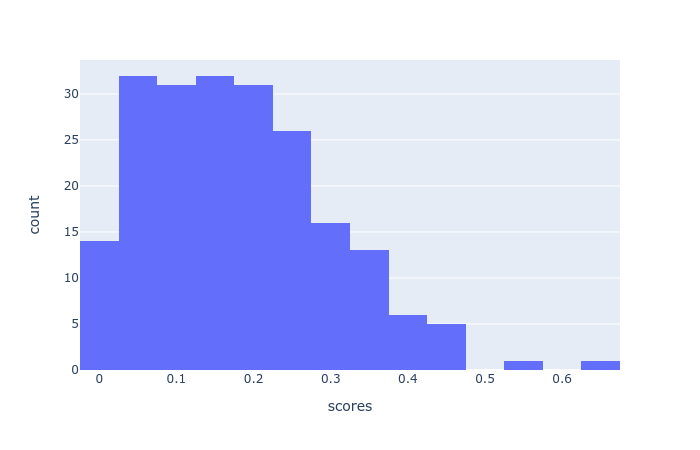

In [223]:
fig = px.histogram(df_free_scores,  x='scores')
fig.show()
# As we might expect, a lower distribution of scores when the docking isn't tethered

# MUCH MORE ANALYSIS NEEDED
.. but the basics seem in place